In [1]:
import sys
print(sys.executable)

c:\Users\dima\Desktop\tndh_ds_demo\env\python.exe


In [2]:
import os
print(os.getcwd())

c:\Users\dima\Documents\ds_projects\my-portfolio


# In-Depth Analysis of Serenely Meditation App Data

This notebook performs an in-depth analysis of the Serenely meditation app data, focusing on creating a portfolio-quality project. The analysis incorporates advanced feature engineering, user segmentation, predictive modeling, and model interpretation to derive actionable insights.

## 1. Setup and Data Loading
This section imports the necessary Python libraries and loads the three datasets: app usage, user demographics, and user experience surveys. The datasets are then merged into a single DataFrame for analysis.

In [3]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import shap
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# --- Load Data ---
try:
    usage_df = pd.read_csv("App_usage_data_-_Humu_case_study.csv")
    demographics_df = pd.read_csv("Demographics_-_Humu_case_study.csv")
    survey_df = pd.read_csv("User_experience_survey_-_Humu_case_study.csv")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the CSV files are in the same directory as this script.")

# --- Initial Merge & Cleaning ---
# Reshape survey data from long to wide
survey_wide_df = survey_df.pivot_table(index='userid', columns='time', values=survey_df.columns.drop(['userid', 'time']))
survey_wide_df.columns = ['_'.join(col) for col in survey_wide_df.columns.values]
survey_wide_df.reset_index(inplace=True)

# Merge all three dataframes
data = pd.merge(demographics_df, usage_df, on='userid', how='left')
data = pd.merge(data, survey_wide_df, on='userid', how='left')

print("Data loaded and merged successfully.")
print(f"Initial shape of combined data: {data.shape}")
data.head()

Data loaded and merged successfully.
Initial shape of combined data: (3811, 26)


c:\Users\dima\Desktop\tndh_ds_demo\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,userid,age_range,gender,metro_area,day1,day2,day3,day4,day5,day6,...,day13,day14,able_focus_present_sign up,easy_new_habits_sign up,easy_to_concet_sign up,enjoy_reg_sched_sign up,expect_app_help_sign up,found_app_help_post-14 days,recently_stressed_post-14 days,recently_stressed_sign up
0,1,25 to 34,female,NYC,2,1,1,1,1,0,...,1.0,1.0,6.0,7.0,6.0,6.0,3.0,5.0,5.0,5.0
1,2,25 to 34,female,LA,1,1,1,0,0,0,...,1.0,0.0,6.0,6.0,4.0,4.0,5.0,7.0,3.0,7.0
2,3,45 to 54,female,SF,1,1,4,0,0,0,...,1.0,1.0,4.0,5.0,5.0,4.0,2.0,6.0,4.0,7.0
3,4,25 to 34,female,NYC,0,0,0,0,0,0,...,NaN,NaN,4.0,6.0,4.0,7.0,1.0,4.0,5.0,5.0
4,5,25 to 34,female,CHI,1,0,0,0,1,2,...,0.0,NaN,4.0,5.0,5.0,3.0,3.0,7.0,7.0,4.0


## 2. Advanced Feature Engineering
Here, new features are created to capture user behavior more effectively. This includes defining churn, calculating usage trends, and measuring changes in user sentiment over the first 14 days.

In [4]:
# This will print a list of all column names in your DataFrame
print("Columns available in the 'data' DataFrame:")
print(list(data.columns))

Columns available in the 'data' DataFrame:
['userid', 'age_range', 'gender', 'metro_area', 'day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'day10', 'day11', 'day12', 'day13', 'day14', 'able_focus_present_sign up', 'easy_new_habits_sign up', 'easy_to_concet_sign up', 'enjoy_reg_sched_sign up', 'expect_app_help_sign up', 'found_app_help_post-14 days', 'recently_stressed_post-14 days', 'recently_stressed_sign up']


In [5]:
print("Starting advanced feature engineering...")

# --- Churn and Usage Metrics ---
usage_days = [f'day{i}' for i in range(1, 15)]
data['churned'] = data['day14'].isna().astype(int)

# --- Usage Trend Calculation ---
def calculate_trend(row):
    days = np.arange(1, 15)
    # Use only non-NA values for trend calculation
    usage = row[usage_days].dropna()
    if len(usage) < 2:
        return 0
    
    # Simple linear regression to find the slope (trend)
    model = LinearRegression()
    model.fit(np.arange(1, len(usage) + 1).reshape(-1, 1), usage.values.reshape(-1, 1))
    return model.coef_[0][0]

print("Calculating usage trends for each user...")
data['usage_trend'] = data.apply(calculate_trend, axis=1)

# Now fill NaNs with 0 for calculation purposes
data[usage_days] = data[usage_days].fillna(0)

data['total_usage'] = data[usage_days].sum(axis=1)
data['days_active'] = (data[usage_days] > 0).sum(axis=1)
data['usage_consistency'] = data[usage_days].std(axis=1)
data['avg_daily_usage_when_active'] = data['total_usage'] / data['days_active'].replace(0, 1)


# --- Sentiment Change Metrics ---
# Calculate the change in sentiment for questions asked at both sign-up and post-14

# The column 'found_app_help_sign up' does not exist in the data, so we can only calculate stress_change.
sentiment_cols = {
    'recently_stressed': ('recently_stressed_sign up', 'recently_stressed_post-14 days'),
}

data['stress_change'] = data[sentiment_cols['recently_stressed'][1]] - data[sentiment_cols['recently_stressed'][0]]

# We have to remove the 'helpfulness_change' calculation as the required column is missing.
# data['helpfulness_change'] = data[sentiment_cols['found_app_help'][1]] - data[sentiment_cols['found_app_help'][0]]

# Rename sign-up survey columns for clarity in modeling
data.rename(columns={
    'expect_app_help_sign up': 'initial_expect_help',
    'easy_to_concet_sign up': 'initial_easy_to_concentrate',
    'able_focus_present_sign up': 'initial_focus_present',
    'easy_new_habits_sign up': 'initial_easy_new_habits',
    'enjoy_reg_sched_sign up': 'initial_enjoy_schedule',
    'recently_stressed_sign up': 'initial_stress'
}, inplace=True)

print("Sentiment features adjusted for available data.")

Starting advanced feature engineering...
Calculating usage trends for each user...
Sentiment features adjusted for available data.


## 3. Behavioral User Segmentation (K-Means Clustering)
K-Means clustering is used to group users into distinct personas based on their behavior. The Elbow Method helps determine the optimal number of clusters.

Performing user segmentation with K-Means clustering...


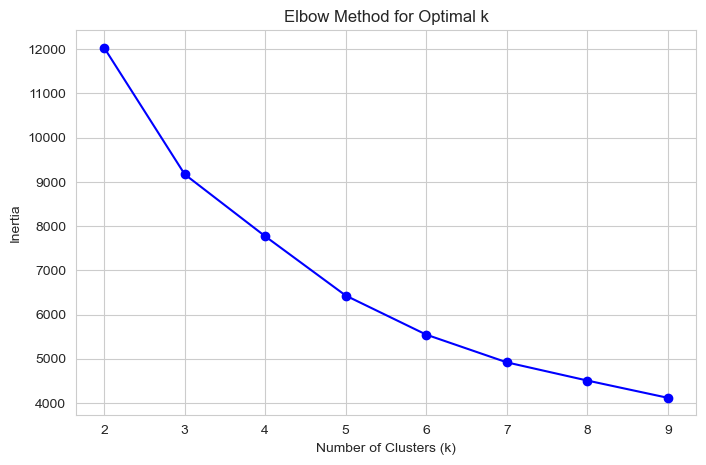

In [6]:
print("Performing user segmentation with K-Means clustering...")

# Select features for clustering
cluster_features = [
    'total_usage',
    'days_active',
    'usage_consistency',
    'usage_trend',
    'churned'
]

# Prepare the data for clustering
cluster_data = data[cluster_features].copy()
cluster_data.fillna(cluster_data.mean(), inplace=True) # Fill any remaining NaNs

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_data)

# --- Elbow Method to find optimal K ---
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

Based on the elbow plot, k=4 appears to be a good choice. Now, we fit the K-Means model with 4 clusters and profile the resulting personas.

In [7]:
# --- Fit K-Means with chosen K and Profile Clusters ---
OPTIMAL_K = 4
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
data['user_persona_cluster'] = kmeans.fit_predict(scaled_features)

print(f"\nProfiling {OPTIMAL_K} User Personas:")
persona_profiles = data.groupby('user_persona_cluster')[cluster_features].mean()
print(persona_profiles)

# Create descriptive names for the personas based on the profiles
# We sort by a key metric to assign labels consistently.
sorted_profiles = persona_profiles.sort_values('total_usage')
persona_map = {
    sorted_profiles.index[0]: "Early Churners",
    sorted_profiles.index[1]: "Fading Casuals",
    sorted_profiles.index[2]: "Consistent Dabblers",
    sorted_profiles.index[3]: "Power Users",
}
data['user_persona'] = data['user_persona_cluster'].map(persona_map)

print("\nPersona names assigned:")
print(data[['userid', 'user_persona']].head())


Profiling 4 User Personas:
                      total_usage  days_active  usage_consistency  \
user_persona_cluster                                                
0                       14.399790     8.713536           1.050092   
1                        7.425598     4.969823           0.828187   
2                        0.990373     0.825511           0.207392   
3                        8.681051     5.508443           0.894453   

                      usage_trend   churned  
user_persona_cluster                         
0                        0.012122  0.026233  
1                       -0.017354  0.000000  
2                       -0.005074  0.304452  
3                       -0.020597  1.000000  

Persona names assigned:
   userid         user_persona
0       1          Power Users
1       2       Fading Casuals
2       3          Power Users
3       4       Early Churners
4       5  Consistent Dabblers


## 4. Predictive Modeling (Churn & Engagement)
Two separate LightGBM models are built:
1. A classification model to predict user churn.
2. A regression model to predict the total usage for users who do not churn.

In [8]:
print("Building predictive models...")

# --- Prepare data for models ---
model_data = data.copy()

# One-hot encode categorical features
categorical_cols = ['gender', 'metro_area', 'age_range']
model_data = pd.get_dummies(model_data, columns=categorical_cols, drop_first=True)

# Define feature set (X) and targets (y)
features_to_drop = [
    'userid', 'user_persona_cluster', 'user_persona', # Identifiers/leaky features
    'churned', 'total_usage', # Targets
    # Drop post-survey data that would leak info about churn/usage
    'recently_stressed_post-14 days', 'found_app_help_post-14 days',
    'stress_change', 'helpfulness_change'
] + usage_days

# Add any other post-survey columns to the drop list
post_survey_cols = [col for col in model_data.columns if 'post-14 days' in col]
features_to_drop.extend(post_survey_cols)

# Define feature set X
X = model_data.drop(columns=features_to_drop, errors='ignore')
# Ensure all columns are numeric, filling NaNs
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)


# --- Model 1: Churn Prediction (Classification) ---
print("Training Churn Prediction Model...")
y_churn = data['churned']

lgb_churn = lgb.LGBMClassifier(random_state=42)
lgb_churn.fit(X, y_churn)

# --- Model 2: Engagement Prediction (Regression) ---
# For users who did NOT churn
print("Training Engagement Prediction Model...")
non_churners = data[data['churned'] == 0]
X_engage = X.loc[non_churners.index]
y_engage = non_churners['total_usage']

lgb_engage = lgb.LGBMRegressor(random_state=42)
lgb_engage.fit(X_engage, y_engage)

print("Models trained successfully.")

Building predictive models...
Training Churn Prediction Model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1344, number of negative: 2467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 541
[LightGBM] [Info] Number of data points in the train set: 3811, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352663 -> initscore=-0.607353
[LightGBM] [Info] Start training from score -0.607353
Training Engagement Prediction Model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

## 5. Model Interpretation with SHAP
SHAP (SHapley Additive exPlanations) is used to interpret the black-box LightGBM models. This helps explain which features are driving the predictions for both churn and engagement, providing clear and actionable insights.


Generating SHAP plots for model interpretation...
Churn model feature importance plot saved.
Detected numpy array format for SHAP values. Using the array directly.
Churn model SHAP summary plot saved.
Engagement model feature importance plot saved.
Engagement model SHAP plots saved.


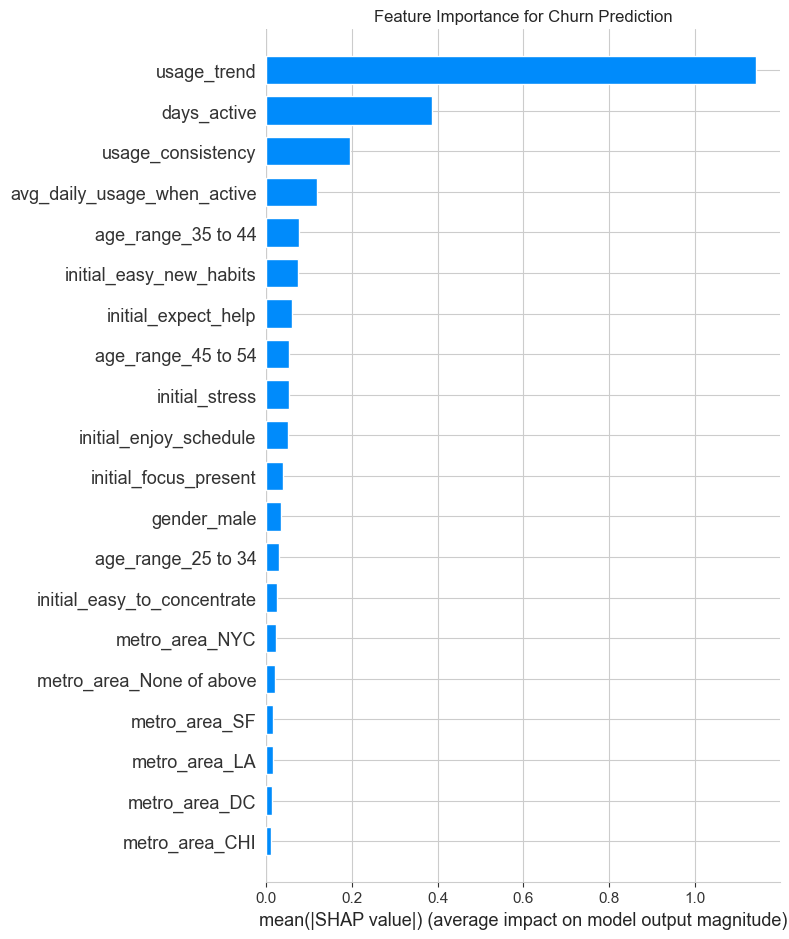

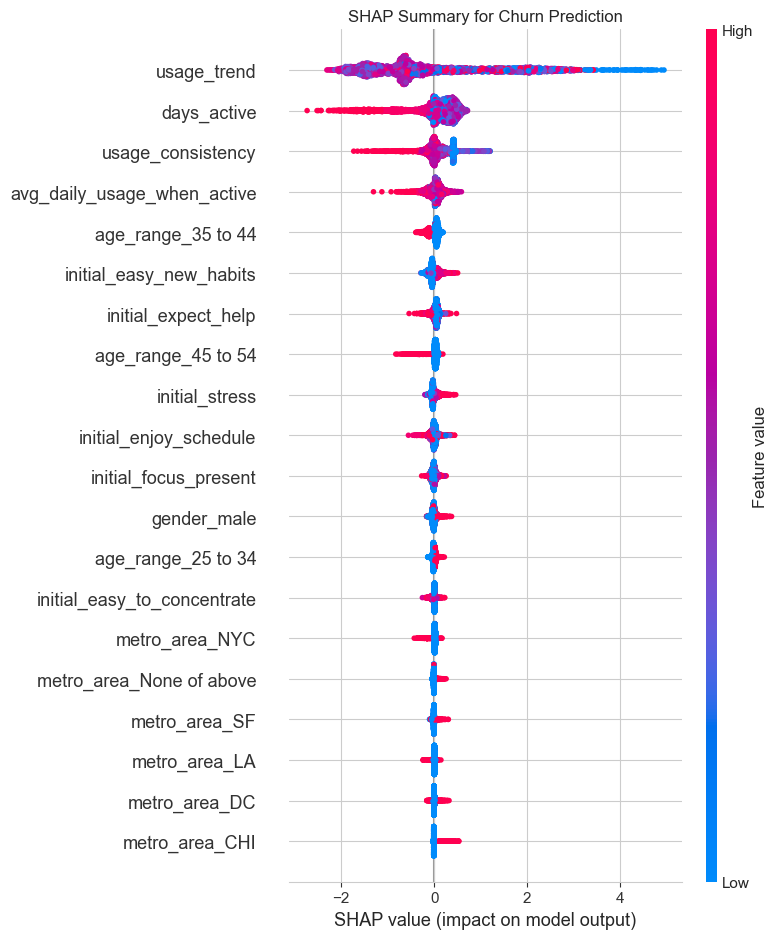

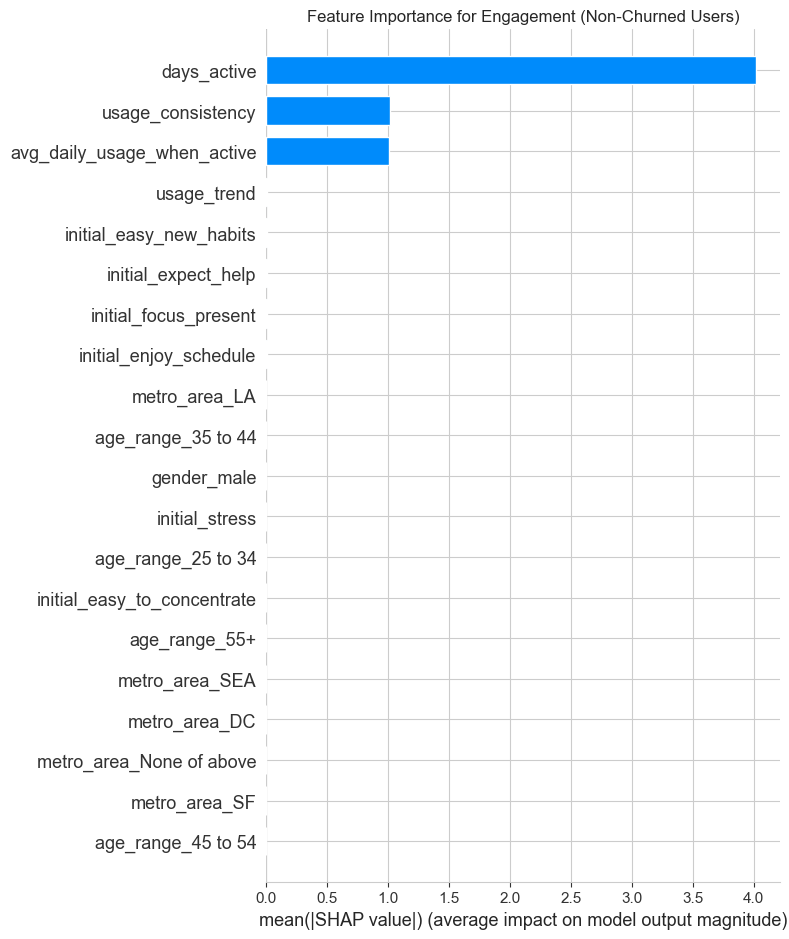

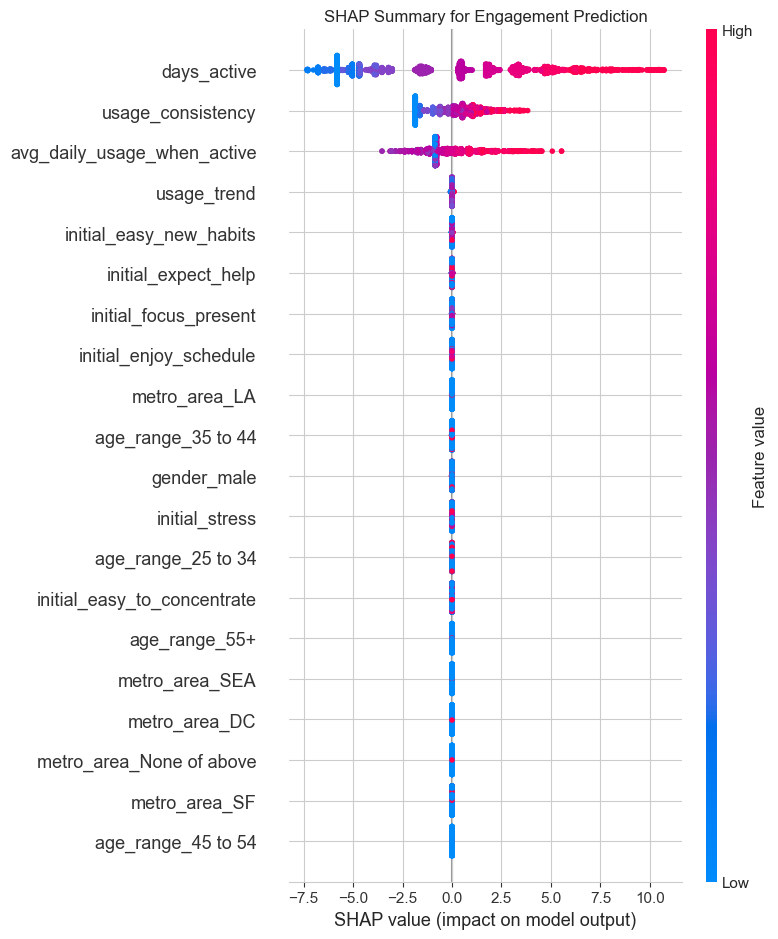

In [9]:
# --- 5. MODEL INTERPRETATION WITH SHAP (Corrected Code) ---
print("\nGenerating SHAP plots for model interpretation...")

# --- SHAP for Churn Model ---
explainer_churn = shap.TreeExplainer(lgb_churn)
shap_values_churn = explainer_churn.shap_values(X)

# --- Create Churn Model Plots ---
# The bar plot for feature importance usually works with either format
plt.figure()
shap.summary_plot(shap_values_churn, X, plot_type="bar", show=False)
plt.title("Feature Importance for Churn Prediction")
plt.tight_layout()
plt.savefig('churn_shap_importance.png')
print("Churn model feature importance plot saved.")

# The beeswarm summary plot needs the SHAP values for the "churn" class.
# We add a check to handle different library versions gracefully.
plt.figure()

# If shap_values is a list (old behavior), it contains values for both classes. We want the second one (for class 1).
if isinstance(shap_values_churn, list):
    print("Detected list format for SHAP values. Using element 1 for churn class.")
    shap.summary_plot(shap_values_churn[1], X, show=False)
# If it's not a list (new behavior), it's a single array of values for the positive class.
else:
    print("Detected numpy array format for SHAP values. Using the array directly.")
    shap.summary_plot(shap_values_churn, X, show=False)

plt.title("SHAP Summary for Churn Prediction")
plt.tight_layout()
plt.savefig('churn_shap_summary.png')
print("Churn model SHAP summary plot saved.")


# --- SHAP for Engagement Model (This part should be fine as it's a regression model) ---
explainer_engage = shap.TreeExplainer(lgb_engage)
shap_values_engage = explainer_engage.shap_values(X_engage)

plt.figure()
shap.summary_plot(shap_values_engage, X_engage, plot_type="bar", show=False)
plt.title("Feature Importance for Engagement (Non-Churned Users)")
plt.tight_layout()
plt.savefig('engagement_shap_importance.png')
print("Engagement model feature importance plot saved.")

plt.figure()
shap.summary_plot(shap_values_engage, X_engage, show=False)
plt.title("SHAP Summary for Engagement Prediction")
plt.tight_layout()
plt.savefig('engagement_shap_summary.png')
print("Engagement model SHAP plots saved.")

Engagement Model SHAP Plots:


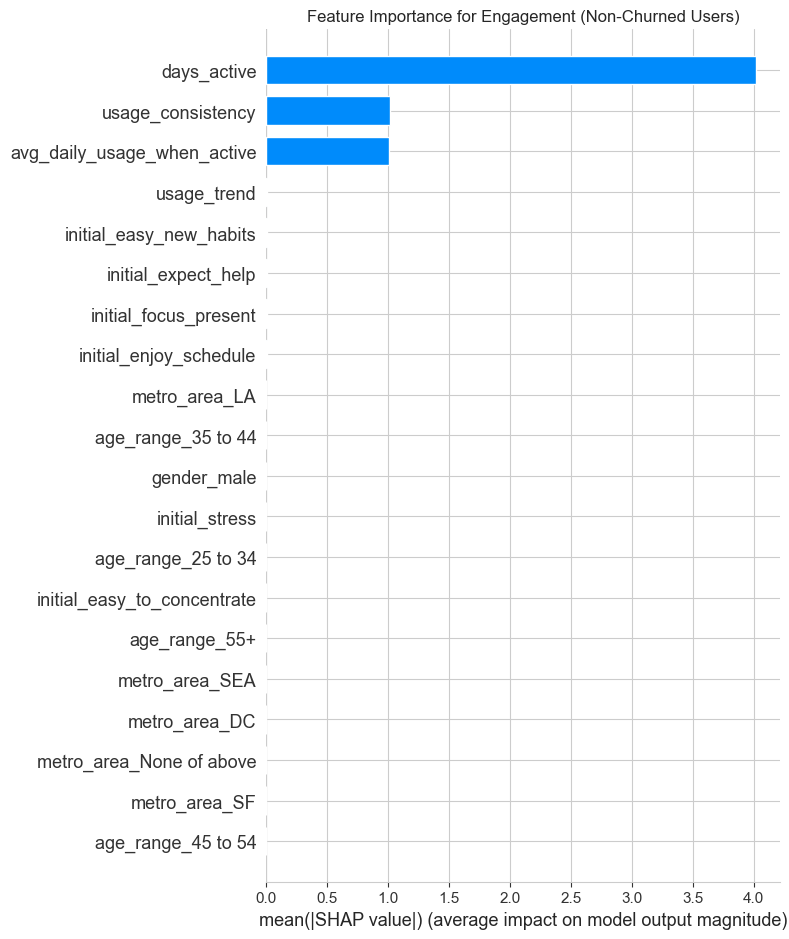

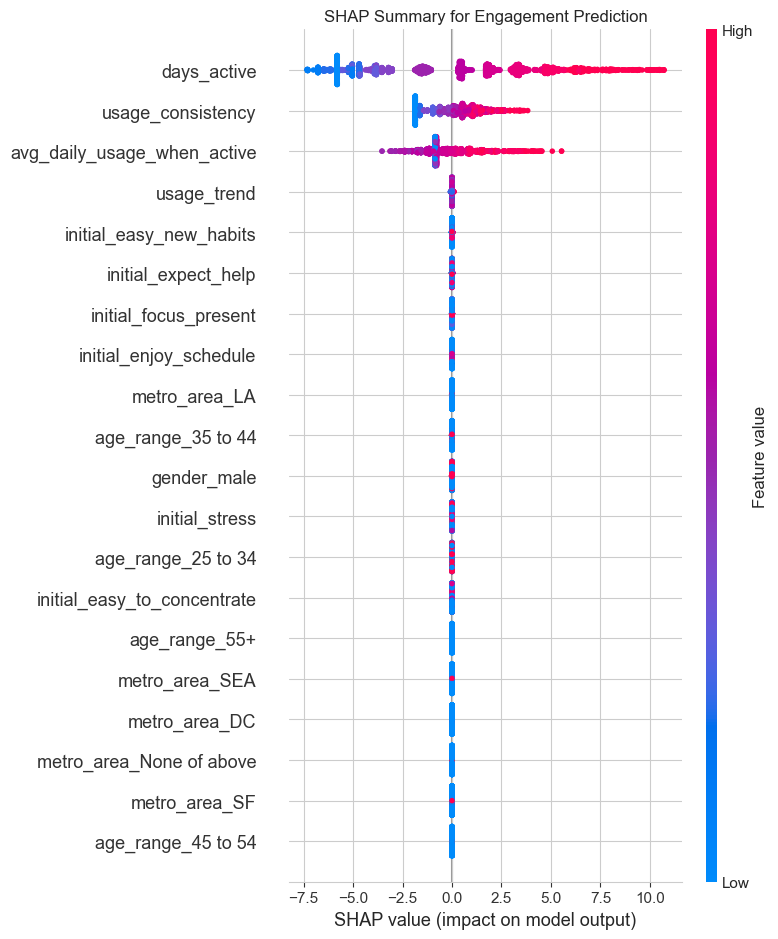

In [10]:
# --- SHAP for Engagement Model ---
explainer_engage = shap.TreeExplainer(lgb_engage)
shap_values_engage = explainer_engage.shap_values(X_engage)

print("Engagement Model SHAP Plots:")
plt.figure()
shap.summary_plot(shap_values_engage, X_engage, plot_type="bar", show=False)
plt.title("Feature Importance for Engagement (Non-Churned Users)")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(shap_values_engage, X_engage, show=False)
plt.title("SHAP Summary for Engagement Prediction")
plt.tight_layout()
plt.show()

## 6. Final Recommendations

Based on the analysis, here are the key data-driven recommendations:

**1. Focus on the First 7 Days to Combat Churn:**
   - **Insight**: The `usage_trend` and `days_active` features are top predictors of churn. Users whose usage fades in the first week are highly likely to churn.
   - **Recommendation**: Implement a "First Week Rescue" program. If a user is inactive for 2-3 consecutive days within their first week, trigger a targeted push notification or email with a gentle nudge, like "Ready for your next 5-minute session?"

**2. Target Personas with Tailored Strategies:**
   - **Insight**: We identified four distinct personas: Power Users, Consistent Dabblers, Fading Casuals, and Early Churners.
   - **Recommendation for "Fading Casuals"**: This group shows declining interest. A/B test different re-engagement strategies for them, such as introducing new content or highlighting the benefits they reported wanting in their sign-up survey.
   - **Recommendation for "Power Users"**: Nurture this group. They are your best customers. Offer them advanced content, beta features, or a community to keep them engaged long-term.

**3. Leverage Initial Sentiments for Onboarding:**
   - **Insight**: Initial survey answers (e.g., `initial_expect_help`, `initial_enjoy_schedule`) are strong predictors of both engagement and churn.
   - **Recommendation**: Customize the user onboarding flow based on their survey answers. If a user reports high stress and expects the app to help, immediately guide them to a "Stress Relief" program. If they enjoy schedules, prompt them to set a daily meditation reminder. This personalizes the experience from Day 1 and demonstrates value immediately.

**4. Shift Focus from Demographics to Behavior:**
   - **Insight**: While demographics like age and gender have some predictive power, they are far less important than behavioral features (usage patterns) and initial psychographics (survey answers).
   - **Recommendation**: Instead of focusing marketing on "males" (as a previous analysis suggested), focus marketing messages on the *benefits* that appeal to high-engagement users (e.g., "Find your focus," "Build a consistent habit"). Target users based on interests and needs, not just who they are.